In [ ]:
# merge cell metadata from TCR info and DE analysis with MAST

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

/wynton/home/kimlab/hyang7/miniconda3/envs/sc-tutorial/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.0 python-igraph==0.8.0 louvain==0.6.1


In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)

library(ggplot2)
library(plyr)
library(MAST)

In [4]:
path = "/wynton/group/fong/hyang7/bladder_blood_analysis/obj/"
adata_file = path + "bladder_total_adata_multiplex_Tcellonly_w_TCR_info_update.h5ad"
adata = sc.read(adata_file)
adata
# as adata have only 2008 genes, we need to get the raw gene count back and match with

AnnData object with n_obs × n_vars = 157054 × 2028 
    obs: 'RBC', 'batch', 'comp', 'n_counts', 'n_genes', 'patient', 'percent_mito', 'platelet', 'sample', 'tissue', 'treatment', 'louvain', 'leiden', 'umap_density_comp', 'umap_density_treatment', 'umap_density_tissue', 'cell_calls', 'S_score', 'G2M_score', 'phase', 'cell.barcode', 'index_col', 'degree', 'tcr_cluster_id', 'expansion', 'blood_tumor', 'expand', 'tcr_alpha_beta'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_calls_colors', 'comp_colors', 'dendrogram_cell_calls', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'phase_colors', 'tissue_colors', 'treatment_colors', 'umap_density_comp_params', 'umap_density_tissue_params', 'umap_density_treatment_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [7]:
adata.obs['tissue'].value_counts()

blood     124467
tumor      27679
normal      4908
Name: tissue, dtype: int64

In [9]:
adata[(adata.obs['tissue'].isin(['normal']))].obs['sample'].value_counts()

s3normal    1803
s1normal    1482
a4normal     713
a3normal     433
a5normal     339
s2normal     138
Name: sample, dtype: int64

In [6]:
# read adata raw
path = "/wynton/group/fong/hyang7/bladder_blood_analysis/obj/"
adata_file = path + "bladder_total_adata_multiplex_preprocess_9.15.h5ad"
adata_raw = sc.read(adata_file)
adata_raw

AnnData object with n_obs × n_vars = 161278 × 32738 
    obs: 'RBC', 'batch', 'comp', 'n_counts', 'n_genes', 'patient', 'percent_mito', 'platelet', 'sample', 'tissue', 'treatment'
    var: 'gene_ids'

In [7]:
#subset adata_raw to cells in adata_mono
adata_raw = adata_raw[adata.obs.index]
adata_raw

View of AnnData object with n_obs × n_vars = 157054 × 32738 
    obs: 'RBC', 'batch', 'comp', 'n_counts', 'n_genes', 'patient', 'percent_mito', 'platelet', 'sample', 'tissue', 'treatment'
    var: 'gene_ids'

In [8]:
# Checking the total size of the data set
adata_raw.shape

(157054, 32738)

In [9]:
adata_raw.obs = adata.obs

In [10]:
adata = adata_raw

In [11]:
adata.raw = adata

In [12]:
# adata.obs

In [13]:
adata.obs["cell.barcode"] = adata.obs.index.map(lambda x: x[0:14])

In [14]:
adata.obs["cell.barcode"].head()

index
AAACATTGCTTGGA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0    AAACATTGCTTGGA
AAACCGTGCACCAA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0    AAACCGTGCACCAA
AAACCGTGTGCCCT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0    AAACCGTGTGCCCT
AAACGGCTCCTTGC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0    AAACGGCTCCTTGC
AAACGGCTGTCTAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0    AAACGGCTGTCTAG
Name: cell.barcode, dtype: object

In [15]:
adata

AnnData object with n_obs × n_vars = 157054 × 32738 
    obs: 'RBC', 'batch', 'comp', 'n_counts', 'n_genes', 'patient', 'percent_mito', 'platelet', 'sample', 'tissue', 'treatment', 'louvain', 'leiden', 'umap_density_comp', 'umap_density_treatment', 'umap_density_tissue', 'cell_calls', 'S_score', 'G2M_score', 'phase', 'cell.barcode', 'index_col', 'degree', 'tcr_cluster_id', 'expansion', 'blood_tumor', 'expand'
    var: 'gene_ids'

In [17]:
#Write to file
path = "/wynton/group/fong/hyang7/bladder_blood_analysis/obj/"
adata_file = path + "bladder_total_adata_multiplex_Tcellonly_w_TCR_info_update_w_all_genes.h5ad"
adata.write(adata_file)
adata

... storing 'cell.barcode' as categorical


AnnData object with n_obs × n_vars = 157054 × 32738 
    obs: 'RBC', 'batch', 'comp', 'n_counts', 'n_genes', 'patient', 'percent_mito', 'platelet', 'sample', 'tissue', 'treatment', 'louvain', 'leiden', 'umap_density_comp', 'umap_density_treatment', 'umap_density_tissue', 'cell_calls', 'S_score', 'G2M_score', 'phase', 'cell.barcode', 'index_col', 'degree', 'tcr_cluster_id', 'expansion', 'blood_tumor', 'expand'
    var: 'gene_ids'

In [4]:
# read adata
path = "/wynton/group/fong/hyang7/bladder_blood_analysis/obj/"
adata_file = path + "bladder_total_adata_multiplex_Tcellonly_w_TCR_info_update_w_all_genes.h5ad"
adata_tcr = sc.read(adata_file)
adata_tcr

AnnData object with n_obs × n_vars = 63572 × 32738 
    obs: 'RBC', 'batch', 'comp', 'n_counts', 'n_genes', 'patient', 'percent_mito', 'platelet', 'sample', 'tissue', 'treatment', 'louvain', 'leiden', 'umap_density_comp', 'umap_density_treatment', 'umap_density_tissue', 'cell_calls', 'S_score', 'G2M_score', 'phase', 'cell.barcode', 'index_col', 'degree', 'tcr_cluster_id', 'expansion', 'blood_tumor'
    var: 'gene_ids'

# DE analysis with MAST

In [4]:
# read adata
path = "/wynton/group/fong/hyang7/bladder_blood_analysis/obj/"
adata_file = path + "bladder_total_adata_multiplex_Tcellonly_w_TCR_info_update_w_all_genes.h5ad"
adata_tcr = sc.read(adata_file)
adata_tcr

AnnData object with n_obs × n_vars = 157054 × 32738 
    obs: 'RBC', 'batch', 'comp', 'n_counts', 'n_genes', 'patient', 'percent_mito', 'platelet', 'sample', 'tissue', 'treatment', 'louvain', 'leiden', 'umap_density_comp', 'umap_density_treatment', 'umap_density_tissue', 'cell_calls', 'S_score', 'G2M_score', 'phase', 'cell.barcode', 'index_col', 'degree', 'tcr_cluster_id', 'expansion', 'blood_tumor', 'expand', 'tcr_alpha_beta'
    var: 'gene_ids'

In [5]:
adata_tcr.obs.columns

Index(['RBC', 'batch', 'comp', 'n_counts', 'n_genes', 'patient',
       'percent_mito', 'platelet', 'sample', 'tissue', 'treatment', 'louvain',
       'leiden', 'umap_density_comp', 'umap_density_treatment',
       'umap_density_tissue', 'cell_calls', 'S_score', 'G2M_score', 'phase',
       'cell.barcode', 'index_col', 'degree', 'tcr_cluster_id', 'expansion',
       'blood_tumor', 'expand', 'tcr_alpha_beta'],
      dtype='object')

In [6]:
adata_tcr.obs["blood_tumor"].value_counts()

nan           100769
non-shared     49790
shared          6495
Name: blood_tumor, dtype: int64

In [7]:
adata_tcr.obs["cell_calls"].value_counts()

Naive           34759
GZMB+           27399
Mito            23597
CM              21247
GZMK+           19371
CXCL13+         17210
Tregs            8777
Prolif GZMK+     2408
MAIT             1680
Activated         518
IFN+               88
Name: cell_calls, dtype: int64

In [8]:
adata_tcr.shape

(157054, 32738)

In [9]:

adata_tcr = adata_tcr[~(adata_tcr.obs['patient'].isin(['a2']))]
adata_tcr.shape

(136009, 32738)

# DE compare on shared vs non-shared

## Blood & CD4

### Test DE on shared vs non-shared in Blood & CD 4

In [10]:
# DE_input_data = adata_tcr[(adata_tcr.obs['tissue'].isin(['blood'])) & (adata_tcr.obs['comp'].isin(['CD4'])) & (adata_tcr.obs['blood_tumor'].isin(['shared', 'non-shared'])) & (adata_tcr.obs['cell_calls'].isin(['GZMK+']))]
DE_input_data = adata_tcr[(adata_tcr.obs['tissue'].isin(['blood'])) & (adata_tcr.obs['comp'].isin(['CD4'])) & (adata_tcr.obs['blood_tumor'].isin(['shared', 'non-shared'])) ]
DE_input_data.shape

(21543, 32738)

In [11]:
# get the gene list of "RPS","RPL"
ribo_genes = DE_input_data.var_names.str.startswith(("RP"))
non_ribo_genes = ~ribo_genes

In [12]:
DE_input_data = DE_input_data[:, non_ribo_genes]
DE_input_data.shape

(21543, 24813)

In [13]:
DE_input_data.obs["blood_tumor"].value_counts()

non-shared    20336
shared         1207
Name: blood_tumor, dtype: int64

In [14]:
DE_input_data.obs["treatment"].value_counts()

atezo    7996
soc      7613
pre      5934
Name: treatment, dtype: int64

In [15]:
%%R -i DE_input_data   -o shared_de
#  -o tissue_de -o expansion_de 

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(DE_input_data, class = "SingleCellAssay", check_sanity = FALSE)

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)
colData(sca)$treatment = factor(colData(sca)$treatment, levels = c("pre", "atezo","soc"))
colData(sca)$blood_tumor = factor(colData(sca)$blood_tumor, levels = c("non-shared", "shared"))

#Create data subsets for B cell and Plasma cell subpopulations
sca_B <- sca
# sca_B <- subset(sca, with(colData(sca), label_v2=='B')) # B
# sca_Plasma <- subset(sca, with(colData(sca), label_v2=='Plasma1')) # Plasma1


#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")
print(dim(sca_B))
# print(dim(sca_Plasma))
print("")

sca_B_filt = sca_B[rowSums(assay(sca_B)) != 0, ]
# sca_Plasma_filt = sca_Plasma[rowSums(assay(sca_Plasma)) != 0, ]

print("Dimensions after subsetting:")
print(dim(sca_B_filt))
# print(dim(sca_Plasma_filt))


#Define & run hurdle model - B cell
# zlmCond_B<- zlm(formula = ~comp + tissue + treatment + cell_calls + degree + expansion + blood_tumor + patient + n_genes, sca=sca_B_filt)
# zlmCond_B<- zlm(formula = ~comp + tissue + treatment + degree + expansion + blood_tumor + patient + n_genes, sca=sca_B_filt)
# zlmCond_B<- zlm(formula = ~comp + tissue + treatment + expansion + patient + n_genes, sca=sca_B_filt)
# zlmCond_B<- zlm(formula = ~ expansion + patient + n_genes, sca=sca_B_filt)
zlmCond_B<- zlm(formula = ~ blood_tumor + treatment + patient + n_genes, sca=sca_B_filt)

# output treatmentatezo
summaryCond_B <- summary(zlmCond_B, doLRT='blood_tumorshared')
summaryDt_B <- summaryCond_B$datatable

print(summaryCond_B)
# print(summaryDt_B)


result_B <- merge(summaryDt_B[contrast=='blood_tumorshared' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_B[contrast=='blood_tumorshared' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_B[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
shared_de = result_B[result_B$FDR<0.01,, drop=F]
shared_de = shared_de[order(shared_de$FDR),]



# # output expansione
# summaryCond_B <- summary(zlmCond_B, doLRT='expansionexpand_lt1')
# summaryDt_B <- summaryCond_B$datatable
# result_B <- merge(summaryDt_B[contrast=='expansionexpand_lt1' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
#                  summaryDt_B[contrast=='expansionexpand_lt1' & component=='logFC', .(primerid, coef)],
#                  by='primerid') #logFC coefficients

# #Correct for multiple testing (FDR correction) and filtering
# result_B[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
# expansion_de = result_B[result_B$FDR<0.01,, drop=F]
# expansion_de = expansion_de[order(expansion_de$FDR),]



# # output tissue
# summaryCond_B <- summary(zlmCond_B, doLRT='tissuetumor')
# summaryDt_B <- summaryCond_B$datatable
# result_B <- merge(summaryDt_B[contrast=='tissuetumor' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
#                  summaryDt_B[contrast=='tissuetumor' & component=='logFC', .(primerid, coef)],
#                  by='primerid') #logFC coefficients

# #Correct for multiple testing (FDR correction) and filtering
# result_B[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
# tissue_de = result_B[result_B$FDR<0.01,, drop=F]
# tissue_de = tissue_de[order(tissue_de$FDR),]


[1] "Dimensions before subsetting:"
[1] 24813 21543
[1] ""
[1] "Dimensions after subsetting:"
[1] 15445 21543
Fitted zlm with top 2 genes per contrast:
( log fold change Z-score )
 primerid blood_tumorshared n_genes patienta4 patienta5 patients1 patients2
 B2M        39.9*            190.4*   10.5      48.1*     11.5      -3.5   
 CD69       -9.5              15.7     9.1      20.6      -9.9     -11.2   
 EEF1A1    -21.5              62.3   -34.4*    -13.7       1.9       8.5   
 EIF1       -8.8              78.7     8.9      41.2*     -4.9      13.9   
 JUNB      -16.6              34.1     7.0       3.8     -20.2     -20.5*  
 LTB       -24.0*             59.7   -19.0     -16.8      -1.4      -9.7   
 MALAT1     -5.1             115.7    27.1*     40.9     -19.7      -0.6   
 TMSB4X     10.2             216.1*   19.1      10.8      -7.7     -19.3   
 TSC22D3    -1.9              30.3    -1.0      25.1      34.3*     14.2   
 TXNIP      -6.1              57.0     0.8      12.0      45

In [19]:
#Show top 20 differentially expressed genes for B cell (up- and down-regulated)
print(shared_de.shape)
shared_de[:20]

(1087, 5)


,Unnamed: 0,primerid,Pr(>Chisq),coef,FDR
0,1,B2M,0.000000e+00,15.264846,0.000000e+00
1,2,CCL5,0.000000e+00,2.809457,0.000000e+00
2,3,GNLY,0.000000e+00,1.660506,0.000000e+00
3,4,GZMA,0.000000e+00,0.483801,0.000000e+00
4,5,GZMH,0.000000e+00,0.386399,0.000000e+00
5,6,LTB,0.000000e+00,-3.467594,0.000000e+00
6,7,NKG7,0.000000e+00,2.570190,0.000000e+00
7,8,CST7,1.423966e-234,0.207905,2.749144e-231
8,9,FGFBP2,1.681787e-216,0.217667,2.886133e-213
9,10,HOPX,5.561485e-138,0.080501,8.589714e-135


In [20]:
# save output to csv file
pd.DataFrame(shared_de).to_csv('../DE_results/DE_compare_on_shared_subset_data_by_blood_CD4_all_cell_types_update_fix_sampleID.csv')

In [12]:
shared_de = pd.read_csv('../DE_results/DE_compare_on_shared_subset_data_by_blood_CD4_all_cell_types_update_fix_sampleID.csv')  

In [13]:
shared_de.head(8)

,Unnamed: 0,Unnamed: 0.1,primerid,Pr(>Chisq),coef,FDR
0,0,1,B2M,0.000000e+00,15.264846,0.000000e+00
1,1,2,CCL5,0.000000e+00,2.809457,0.000000e+00
2,2,3,GNLY,0.000000e+00,1.660506,0.000000e+00
3,3,4,GZMA,0.000000e+00,0.483801,0.000000e+00
4,4,5,GZMH,0.000000e+00,0.386399,0.000000e+00
5,5,6,LTB,0.000000e+00,-3.467594,0.000000e+00
6,6,7,NKG7,0.000000e+00,2.570190,0.000000e+00
7,7,8,CST7,1.423966e-234,0.207905,2.749144e-231


In [14]:
shared_de=shared_de.replace(0,1.0e-250) 

In [15]:
# shared_de['FDR'] = shared_de['FDR'].replace([0,1,2,3],[1.0e-265,1.0e-260,1.0e-255,1.0e-250])

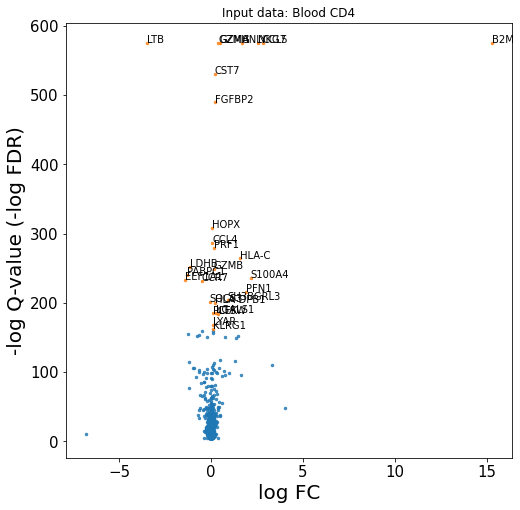

In [16]:
#Volcano plot of results
shared_de['-logQ'] = -np.log(shared_de['FDR'])
lowqval_de = shared_de.loc[shared_de['-logQ'] > 160]
other_de = shared_de.loc[shared_de['-logQ'] < 160]

fig, ax = plt.subplots()
sb.regplot(other_de['coef'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
sb.regplot(lowqval_de['coef'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
ax.set_xlabel("log FC", fontsize=20)
ax.set_ylabel("-log Q-value (-log FDR)", fontsize=20)
ax.set_title('Input data: Blood CD4')
ax.tick_params(labelsize=15)

# Label names and positions
# x = [i-0.2 for i in lowqval_de['coef']]
# y = [i+10 for i in lowqval_de['-logQ']]
x = [i for i in lowqval_de['coef']]
y = [i for i in lowqval_de['-logQ']]
labels = lowqval_de['primerid']

# Show only some labels to avoid overcrowding the figure
to_remove = np.where([i < 160 for i in y])[0]
labels = ["" if i in to_remove else lab for i,lab in enumerate(labels) ]

#Move up two labels
# y = [y[i]+10 if txt == 'TNFAIP3' else y[i] for i,txt in enumerate(labels)]
# y = [y[i]+20 if txt == 'HSPD1' else y[i] for i,txt in enumerate(labels)]

#Move down one label
# y = [y[i]-20 if txt == 'FKBP4' else y[i] for i,txt in enumerate(labels)]

# to remove all labels, comment out next two lines
for i,txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))
plt.savefig('/wynton/group/fong/hyang7/bladder_blood_analysis/plots/DE_figures/Volcano_plot_DE_compare_on_shared_subset_data_by_blood_CD4_all_cell_types_update_wo_label_fix_sampleID_w_label.pdf',dpi=300)
plt.show()

## Blood & CD8

### Test DE on shared vs non-shared in Blood & CD 8

In [26]:
# DE_input_data = adata_tcr[(adata_tcr.obs['tissue'].isin(['blood'])) & (adata_tcr.obs['comp'].isin(['CD8'])) & (adata_tcr.obs['blood_tumor'].isin(['shared', 'non-shared'])) & (adata_tcr.obs['cell_calls'].isin(['GZMK+']))]
DE_input_data = adata_tcr[(adata_tcr.obs['tissue'].isin(['blood'])) & (adata_tcr.obs['comp'].isin(['CD8'])) & (adata_tcr.obs['blood_tumor'].isin(['shared', 'non-shared'])) ]
DE_input_data.shape

(16892, 32738)

In [27]:
# get the gene list of "RPS","RPL"
ribo_genes = DE_input_data.var_names.str.startswith(("RP"))
non_ribo_genes = ~ribo_genes
DE_input_data = DE_input_data[:, non_ribo_genes]
DE_input_data.shape

(16892, 24813)

In [28]:
DE_input_data.obs["blood_tumor"].value_counts()

non-shared    12727
shared         4165
Name: blood_tumor, dtype: int64

In [29]:
%%R -i DE_input_data   -o shared_de
#  -o tissue_de -o expansion_de 

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(DE_input_data, class = "SingleCellAssay", check_sanity = FALSE)

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)
colData(sca)$treatment = factor(colData(sca)$treatment, levels = c("pre", "atezo","soc"))
colData(sca)$blood_tumor = factor(colData(sca)$blood_tumor, levels = c("non-shared", "shared"))

#Create data subsets for B cell and Plasma cell subpopulations
sca_B <- sca
# sca_B <- subset(sca, with(colData(sca), label_v2=='B')) # B
# sca_Plasma <- subset(sca, with(colData(sca), label_v2=='Plasma1')) # Plasma1


#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")
print(dim(sca_B))
# print(dim(sca_Plasma))
print("")

sca_B_filt = sca_B[rowSums(assay(sca_B)) != 0, ]
# sca_Plasma_filt = sca_Plasma[rowSums(assay(sca_Plasma)) != 0, ]

print("Dimensions after subsetting:")
print(dim(sca_B_filt))
# print(dim(sca_Plasma_filt))


#Define & run hurdle model - B cell
# zlmCond_B<- zlm(formula = ~comp + tissue + treatment + cell_calls + degree + expansion + blood_tumor + patient + n_genes, sca=sca_B_filt)
# zlmCond_B<- zlm(formula = ~comp + tissue + treatment + degree + expansion + blood_tumor + patient + n_genes, sca=sca_B_filt)
# zlmCond_B<- zlm(formula = ~comp + tissue + treatment + expansion + patient + n_genes, sca=sca_B_filt)
# zlmCond_B<- zlm(formula = ~ expansion + patient + n_genes, sca=sca_B_filt)
zlmCond_B<- zlm(formula = ~ blood_tumor + treatment + patient + n_genes, sca=sca_B_filt)

# output treatmentatezo
summaryCond_B <- summary(zlmCond_B, doLRT='blood_tumorshared')
summaryDt_B <- summaryCond_B$datatable

print(summaryCond_B)
# print(summaryDt_B)


result_B <- merge(summaryDt_B[contrast=='blood_tumorshared' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_B[contrast=='blood_tumorshared' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_B[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
shared_de = result_B[result_B$FDR<0.01,, drop=F]
shared_de = shared_de[order(shared_de$FDR),]



# # output expansione
# summaryCond_B <- summary(zlmCond_B, doLRT='expansionexpand_lt1')
# summaryDt_B <- summaryCond_B$datatable
# result_B <- merge(summaryDt_B[contrast=='expansionexpand_lt1' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
#                  summaryDt_B[contrast=='expansionexpand_lt1' & component=='logFC', .(primerid, coef)],
#                  by='primerid') #logFC coefficients

# #Correct for multiple testing (FDR correction) and filtering
# result_B[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
# expansion_de = result_B[result_B$FDR<0.01,, drop=F]
# expansion_de = expansion_de[order(expansion_de$FDR),]



# # output tissue
# summaryCond_B <- summary(zlmCond_B, doLRT='tissuetumor')
# summaryDt_B <- summaryCond_B$datatable
# result_B <- merge(summaryDt_B[contrast=='tissuetumor' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
#                  summaryDt_B[contrast=='tissuetumor' & component=='logFC', .(primerid, coef)],
#                  by='primerid') #logFC coefficients

# #Correct for multiple testing (FDR correction) and filtering
# result_B[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
# tissue_de = result_B[result_B$FDR<0.01,, drop=F]
# tissue_de = tissue_de[order(tissue_de$FDR),]


[1] "Dimensions before subsetting:"
[1] 24813 16892
[1] ""
[1] "Dimensions after subsetting:"
[1] 15230 16892
Fitted zlm with top 2 genes per contrast:
( log fold change Z-score )
 primerid blood_tumorshared n_genes patienta4 patienta5 patients1 patients2
 B2M        19.2             144.9*   -0.0      52.6*      2.2     -14.6   
 BTG1       -7.3              35.3    -6.8       8.5      13.8      26.4*  
 CCL5       15.1              25.8    29.3*     39.0      14.4       7.4   
 GZMK        5.8              12.3    26.0*      8.1       3.8      10.1   
 H3F3B      -2.4              79.3     1.8      45.6*      6.4      15.4   
 HLA-B       9.5             106.4   -13.3      -5.6       6.1       8.5   
 LTB       -20.9*             19.9    -8.3     -13.2      -4.9     -10.3   
 MALAT1     -1.9              54.5     9.3      31.4     -14.5      -8.4   
 NKG7       23.6*             26.6     0.1      32.5       2.9      -8.9   
 PTPRC       8.4              45.6    -6.4      -2.1      -4

In [30]:
#Show top 20 differentially expressed genes for B cell (up- and down-regulated)
print(shared_de.shape)
shared_de[:20]

(564, 4)


,primerid,Pr(>Chisq),coef,FDR
1,NKG7,7.554761e-209,2.413068,1.150590e-204
2,CCL5,1.198647e-192,2.045288,9.127700e-189
3,LTB,7.689295e-160,-1.551476,3.903599e-156
4,GZMH,3.908527e-124,0.697354,1.488171e-120
5,GZMA,2.170634e-116,0.474766,6.611750e-113
6,FGFBP2,5.163692e-89,0.578211,1.310717e-85
7,CST7,6.769174e-86,0.404641,1.472779e-82
8,GNLY,5.550924e-81,1.151929,1.056757e-77
9,B2M,3.241368e-80,6.119141,5.485115e-77
10,EEF1A1,9.513715e-72,-0.773122,1.448939e-68


In [31]:
# save output to csv file
pd.DataFrame(shared_de).to_csv('../DE_results/DE_compare_on_shared_subset_data_by_blood_CD8_all_cell_types_update_fix_sampleID.csv')

In [6]:
shared_de = pd.read_csv('../DE_results/DE_compare_on_shared_subset_data_by_blood_CD8_all_cell_types_update_fix_sampleID.csv')  

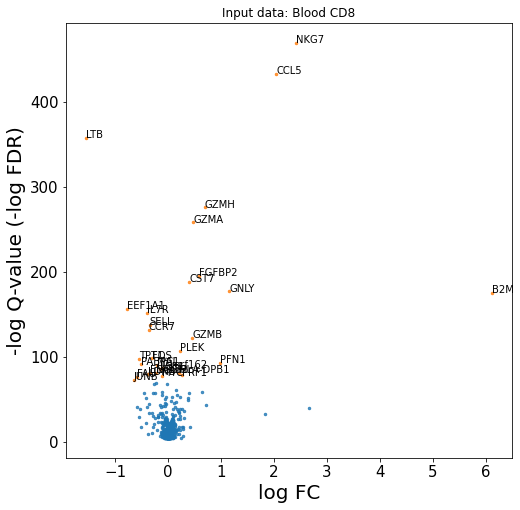

In [7]:
#Volcano plot of results
shared_de['-logQ'] = -np.log(shared_de['FDR'])
lowqval_de = shared_de.loc[shared_de['-logQ'] > 70]
other_de = shared_de.loc[shared_de['-logQ'] < 70]

fig, ax = plt.subplots()
sb.regplot(other_de['coef'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
sb.regplot(lowqval_de['coef'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
ax.set_xlabel("log FC", fontsize=20)
ax.set_ylabel("-log Q-value (-log FDR)", fontsize=20)
ax.set_title('Input data: Blood CD8')
ax.tick_params(labelsize=15)

# Label names and positions
# x = [i-0.2 for i in lowqval_de['coef']]
# y = [i+10 for i in lowqval_de['-logQ']]
x = [i for i in lowqval_de['coef']]
y = [i for i in lowqval_de['-logQ']]
labels = lowqval_de['primerid']

# Show only some labels to avoid overcrowding the figure
to_remove = np.where([i < 70 for i in y])[0]
labels = ["" if i in to_remove else lab for i,lab in enumerate(labels) ]

#Move up two labels
# y = [y[i]+10 if txt == 'TNFAIP3' else y[i] for i,txt in enumerate(labels)]
# y = [y[i]+20 if txt == 'HSPD1' else y[i] for i,txt in enumerate(labels)]

#Move down one label
# y = [y[i]-20 if txt == 'FKBP4' else y[i] for i,txt in enumerate(labels)]

# to remove all labels, comment out next two lines
for i,txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))
plt.savefig('/wynton/group/fong/hyang7/bladder_blood_analysis/plots/DE_figures/Volcano_plot_DE_compare_on_shared_subset_data_by_blood_CD8_all_cell_types_update_wo_label_fix_sampleID_w_label.pdf',dpi=300)

plt.show()

## Tumor & CD8

### Test DE on shared vs non-shared in Tumor & CD 8

In [34]:
# DE_input_data = adata_tcr[(adata_tcr.obs['tissue'].isin(['tumor'])) & (adata_tcr.obs['comp'].isin(['CD8'])) & (adata_tcr.obs['blood_tumor'].isin(['shared', 'non-shared'])) & (adata_tcr.obs['cell_calls'].isin(['GZMK+']))]
DE_input_data = adata_tcr[(adata_tcr.obs['tissue'].isin(['tumor'])) & (adata_tcr.obs['comp'].isin(['CD8'])) & (adata_tcr.obs['blood_tumor'].isin(['shared', 'non-shared'])) ]
DE_input_data.shape

(3935, 32738)

In [35]:
# get the gene list of "RPS","RPL"
ribo_genes = DE_input_data.var_names.str.startswith(("RP"))
non_ribo_genes = ~ribo_genes
DE_input_data = DE_input_data[:, non_ribo_genes]
DE_input_data.shape

(3935, 24813)

In [36]:
DE_input_data.obs["treatment"].value_counts()

soc      2601
atezo    1334
Name: treatment, dtype: int64

In [37]:
%%R -i DE_input_data   -o shared_de
#  -o tissue_de -o expansion_de 

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(DE_input_data, class = "SingleCellAssay", check_sanity = FALSE)

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)
colData(sca)$treatment = factor(colData(sca)$treatment, levels = c("pre", "atezo","soc"))
colData(sca)$blood_tumor = factor(colData(sca)$blood_tumor, levels = c("non-shared", "shared"))

#Create data subsets for B cell and Plasma cell subpopulations
sca_B <- sca
# sca_B <- subset(sca, with(colData(sca), label_v2=='B')) # B
# sca_Plasma <- subset(sca, with(colData(sca), label_v2=='Plasma1')) # Plasma1


#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")
print(dim(sca_B))
# print(dim(sca_Plasma))
print("")

sca_B_filt = sca_B[rowSums(assay(sca_B)) != 0, ]
# sca_Plasma_filt = sca_Plasma[rowSums(assay(sca_Plasma)) != 0, ]

print("Dimensions after subsetting:")
print(dim(sca_B_filt))
# print(dim(sca_Plasma_filt))


#Define & run hurdle model - B cell
# zlmCond_B<- zlm(formula = ~comp + tissue + treatment + cell_calls + degree + expansion + blood_tumor + patient + n_genes, sca=sca_B_filt)
# zlmCond_B<- zlm(formula = ~comp + tissue + treatment + degree + expansion + blood_tumor + patient + n_genes, sca=sca_B_filt)
# zlmCond_B<- zlm(formula = ~comp + tissue + treatment + expansion + patient + n_genes, sca=sca_B_filt)
# zlmCond_B<- zlm(formula = ~ expansion + patient + n_genes, sca=sca_B_filt)
zlmCond_B<- zlm(formula = ~ blood_tumor + treatment + patient + n_genes, sca=sca_B_filt)

# output treatmentatezo
summaryCond_B <- summary(zlmCond_B, doLRT='blood_tumorshared')
summaryDt_B <- summaryCond_B$datatable

print(summaryCond_B)
# print(summaryDt_B)


result_B <- merge(summaryDt_B[contrast=='blood_tumorshared' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_B[contrast=='blood_tumorshared' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_B[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
shared_de = result_B[result_B$FDR<0.01,, drop=F]
shared_de = shared_de[order(shared_de$FDR),]



# # output expansione
# summaryCond_B <- summary(zlmCond_B, doLRT='expansionexpand_lt1')
# summaryDt_B <- summaryCond_B$datatable
# result_B <- merge(summaryDt_B[contrast=='expansionexpand_lt1' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
#                  summaryDt_B[contrast=='expansionexpand_lt1' & component=='logFC', .(primerid, coef)],
#                  by='primerid') #logFC coefficients

# #Correct for multiple testing (FDR correction) and filtering
# result_B[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
# expansion_de = result_B[result_B$FDR<0.01,, drop=F]
# expansion_de = expansion_de[order(expansion_de$FDR),]



# # output tissue
# summaryCond_B <- summary(zlmCond_B, doLRT='tissuetumor')
# summaryDt_B <- summaryCond_B$datatable
# result_B <- merge(summaryDt_B[contrast=='tissuetumor' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
#                  summaryDt_B[contrast=='tissuetumor' & component=='logFC', .(primerid, coef)],
#                  by='primerid') #logFC coefficients

# #Correct for multiple testing (FDR correction) and filtering
# result_B[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
# tissue_de = result_B[result_B$FDR<0.01,, drop=F]
# tissue_de = tissue_de[order(tissue_de$FDR),]


[1] "Dimensions before subsetting:"
[1] 24813  3935
[1] ""
[1] "Dimensions after subsetting:"
[1] 13814  3935
Fitted zlm with top 2 genes per contrast:
( log fold change Z-score )
 primerid blood_tumorshared n_genes patienta4 patienta5 patients1 patients2
 B2M         2.1              73.3*  -29.7*    -17.7      18.7*      2.9   
 FTH1       -4.4*             17.6    -9.8     -14.4      10.9      -6.2   
 HLA-B       1.9              45.5   -23.9     -32.7*      8.0       2.2   
 MALAT1      0.2              30.2   -35.8*    -22.8*     34.0*     23.9*  
 MT-CO1     -1.4              49.1    -2.5      -2.3      14.7     -23.7*  
 NKG7        5.4*             18.4    -4.2       1.2      11.0       5.2   
 TMSB4X      0.2              69.5*  -25.6     -16.7       0.4      -3.4   
 treatmentatezo
   28.8*       
   10.0        
   35.8*       
   28.3        
    5.7        
    4.8        
   21.5        


In [38]:
#Show top 20 differentially expressed genes for B cell (up- and down-regulated)
print(shared_de.shape)
shared_de[:20]

(9, 4)


,primerid,Pr(>Chisq),coef,FDR
1,NKG7,2.168265e-15,1.017218,2.995241e-11
2,FPGT,9.918092e-10,0.007306,6.850426e-06
3,FGFBP2,1.810410e-09,0.079331,8.336334e-06
4,RBPJ,3.155109e-08,-0.177100,1.089617e-04
5,CXCL13,4.213343e-08,-0.498935,1.164063e-04
6,CST7,2.951916e-07,0.247655,6.796293e-04
7,GZMH,7.572574e-07,0.277585,1.494393e-03
8,KIF4A,1.536962e-06,0.014975,2.653948e-03
9,ITFG3,5.519856e-06,-0.003497,8.472365e-03


In [39]:
# save output to csv file
pd.DataFrame(shared_de).to_csv('../DE_results/DE_compare_on_shared_subset_data_by_tumor_CD8_all_cell_types_update_fix_sampleID.csv')

In [8]:
shared_de = pd.read_csv('../DE_results/DE_compare_on_shared_subset_data_by_tumor_CD8_all_cell_types_update_fix_sampleID.csv')  

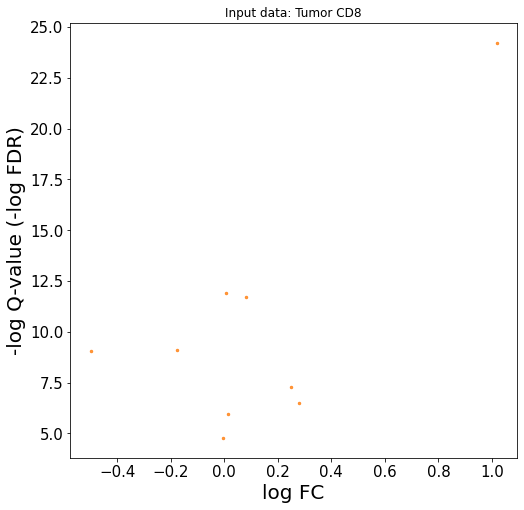

In [9]:
#Volcano plot of results
shared_de['-logQ'] = -np.log(shared_de['FDR'])
lowqval_de = shared_de.loc[shared_de['-logQ'] > 4.5]
other_de = shared_de.loc[shared_de['-logQ'] < 4.5]

fig, ax = plt.subplots()
sb.regplot(other_de['coef'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
sb.regplot(lowqval_de['coef'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
ax.set_xlabel("log FC", fontsize=20)
ax.set_ylabel("-log Q-value (-log FDR)", fontsize=20)
ax.set_title('Input data: Tumor CD8')
ax.tick_params(labelsize=15)

# Label names and positions
# x = [i-0.2 for i in lowqval_de['coef']]
# y = [i+10 for i in lowqval_de['-logQ']]
x = [i for i in lowqval_de['coef']]
y = [i for i in lowqval_de['-logQ']]
labels = lowqval_de['primerid']

# Show only some labels to avoid overcrowding the figure
to_remove = np.where([i < 4.5 for i in y])[0]
labels = ["" if i in to_remove else lab for i,lab in enumerate(labels) ]

#Move up two labels
# y = [y[i]+10 if txt == 'TNFAIP3' else y[i] for i,txt in enumerate(labels)]
# y = [y[i]+20 if txt == 'HSPD1' else y[i] for i,txt in enumerate(labels)]

#Move down one label
# y = [y[i]-20 if txt == 'FKBP4' else y[i] for i,txt in enumerate(labels)]

# for i,txt in enumerate(labels):
#     ax.annotate(txt, (x[i], y[i]))
plt.savefig('/wynton/group/fong/hyang7/bladder_blood_analysis/plots/DE_figures/Volcano_plot_DE_compare_on_shared_subset_data_by_tumor_CD8_all_cell_types_update_fix_sampleID_wo_label.pdf',dpi=300)

plt.show()

## Tumor CD4

### Test DE on shared vs non-shared in Tumor & CD4

In [42]:
# DE_input_data = adata_tcr[(adata_tcr.obs['tissue'].isin(['tumor'])) & (adata_tcr.obs['comp'].isin(['CD4'])) & (adata_tcr.obs['blood_tumor'].isin(['shared', 'non-shared'])) & (adata_tcr.obs['cell_calls'].isin(['GZMK+']))]
DE_input_data = adata_tcr[(adata_tcr.obs['tissue'].isin(['tumor'])) & (adata_tcr.obs['comp'].isin(['CD4'])) & (adata_tcr.obs['blood_tumor'].isin(['shared', 'non-shared'])) ]
DE_input_data.shape

(8013, 32738)

In [43]:
# get the gene list of "RPS","RPL"
ribo_genes = DE_input_data.var_names.str.startswith(("RP"))
non_ribo_genes = ~ribo_genes
DE_input_data = DE_input_data[:, non_ribo_genes]
DE_input_data.shape

(8013, 24813)

In [44]:
DE_input_data.obs["treatment"].value_counts()

atezo    4717
soc      3296
Name: treatment, dtype: int64

In [45]:
%%R -i DE_input_data   -o shared_de
#  -o tissue_de -o expansion_de 

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(DE_input_data, class = "SingleCellAssay", check_sanity = FALSE)

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)
colData(sca)$treatment = factor(colData(sca)$treatment, levels = c("pre", "atezo","soc"))
colData(sca)$blood_tumor = factor(colData(sca)$blood_tumor, levels = c("non-shared", "shared"))

#Create data subsets for B cell and Plasma cell subpopulations
sca_B <- sca
# sca_B <- subset(sca, with(colData(sca), label_v2=='B')) # B
# sca_Plasma <- subset(sca, with(colData(sca), label_v2=='Plasma1')) # Plasma1


#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")
print(dim(sca_B))
# print(dim(sca_Plasma))
print("")

sca_B_filt = sca_B[rowSums(assay(sca_B)) != 0, ]
# sca_Plasma_filt = sca_Plasma[rowSums(assay(sca_Plasma)) != 0, ]

print("Dimensions after subsetting:")
print(dim(sca_B_filt))
# print(dim(sca_Plasma_filt))


#Define & run hurdle model - B cell
# zlmCond_B<- zlm(formula = ~comp + tissue + treatment + cell_calls + degree + expansion + blood_tumor + patient + n_genes, sca=sca_B_filt)
# zlmCond_B<- zlm(formula = ~comp + tissue + treatment + degree + expansion + blood_tumor + patient + n_genes, sca=sca_B_filt)
# zlmCond_B<- zlm(formula = ~comp + tissue + treatment + expansion + patient + n_genes, sca=sca_B_filt)
# zlmCond_B<- zlm(formula = ~ expansion + patient + n_genes, sca=sca_B_filt)
zlmCond_B<- zlm(formula = ~ blood_tumor + treatment + patient + n_genes, sca=sca_B_filt)

# output treatmentatezo
summaryCond_B <- summary(zlmCond_B, doLRT='blood_tumorshared')
summaryDt_B <- summaryCond_B$datatable

print(summaryCond_B)
# print(summaryDt_B)


result_B <- merge(summaryDt_B[contrast=='blood_tumorshared' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_B[contrast=='blood_tumorshared' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_B[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
shared_de = result_B[result_B$FDR<0.01,, drop=F]
shared_de = shared_de[order(shared_de$FDR),]



# # output expansione
# summaryCond_B <- summary(zlmCond_B, doLRT='expansionexpand_lt1')
# summaryDt_B <- summaryCond_B$datatable
# result_B <- merge(summaryDt_B[contrast=='expansionexpand_lt1' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
#                  summaryDt_B[contrast=='expansionexpand_lt1' & component=='logFC', .(primerid, coef)],
#                  by='primerid') #logFC coefficients

# #Correct for multiple testing (FDR correction) and filtering
# result_B[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
# expansion_de = result_B[result_B$FDR<0.01,, drop=F]
# expansion_de = expansion_de[order(expansion_de$FDR),]



# # output tissue
# summaryCond_B <- summary(zlmCond_B, doLRT='tissuetumor')
# summaryDt_B <- summaryCond_B$datatable
# result_B <- merge(summaryDt_B[contrast=='tissuetumor' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
#                  summaryDt_B[contrast=='tissuetumor' & component=='logFC', .(primerid, coef)],
#                  by='primerid') #logFC coefficients

# #Correct for multiple testing (FDR correction) and filtering
# result_B[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
# tissue_de = result_B[result_B$FDR<0.01,, drop=F]
# tissue_de = tissue_de[order(tissue_de$FDR),]


[1] "Dimensions before subsetting:"
[1] 24813  8013
[1] ""
[1] "Dimensions after subsetting:"
[1] 14731  8013
Fitted zlm with top 2 genes per contrast:
( log fold change Z-score )
 primerid blood_tumorshared n_genes patienta4 patienta5 patients1 patients2
 B2M         1.0             136.8*  -25.9*      0.5      19.5       4.4   
 BTG1       -1.1              33.9    -5.5     -26.3*     15.1      -0.0   
 CCL5        6.4*              3.3    -5.3      -5.3       7.2       1.3   
 CD52        2.3              24.2   -14.3     -15.6      10.0       7.2   
 CXCR4       6.2*             17.0    -8.6     -11.6      20.7      -4.6   
 HLA-B       3.8             100.3   -27.2*    -38.4*     10.4      -2.4   
 HLA-C       3.3              72.3     3.8      -0.6      -4.0     -23.3*  
 MALAT1     -3.1              48.6   -12.0       8.4      28.7*     21.3   
 MT-CO1      0.0              89.6     7.5       5.3      21.9     -29.6*  
 TMSB4X     -1.0             108.2*  -25.8     -15.0      -2

In [46]:
#Show top 20 differentially expressed genes for B cell (up- and down-regulated)
print(shared_de.shape)
shared_de[:20]

(114, 4)


,primerid,Pr(>Chisq),coef,FDR
1,CCL5,5.943465e-54,2.463021,4.377659e-50
2,RTN4IP1,4.565062e-54,-0.186025,4.377659e-50
3,NKG7,2.727719e-49,0.944188,1.339401e-45
4,GZMH,1.015812e-33,0.411405,3.740983e-30
5,FGFBP2,2.087145e-27,0.026976,6.149146e-24
6,CCL4,7.769565e-26,1.549598,1.907558e-22
7,GZMA,1.795076e-23,0.462339,3.777609e-20
8,ZNF444,4.299766e-23,0.026897,7.917481e-20
9,GZMB,1.627861e-18,0.310843,2.664447e-15
10,MLYCD,1.030252e-17,0.004397,1.517665e-14


In [47]:
# save output to csv file
pd.DataFrame(shared_de).to_csv('../DE_results/DE_compare_on_shared_subset_data_by_tumor_CD4_all_cell_types_update_fix_sampleID.csv')

In [10]:
shared_de = pd.read_csv('../DE_results/DE_compare_on_shared_subset_data_by_tumor_CD4_all_cell_types_update_fix_sampleID.csv')  

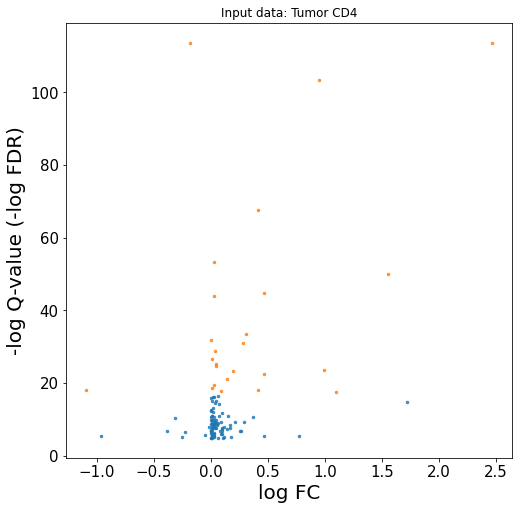

In [11]:
#Volcano plot of results
shared_de['-logQ'] = -np.log(shared_de['FDR'])
lowqval_de = shared_de.loc[shared_de['-logQ'] > 16.5]
other_de = shared_de.loc[shared_de['-logQ'] < 16.5]

fig, ax = plt.subplots()
sb.regplot(other_de['coef'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
sb.regplot(lowqval_de['coef'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
ax.set_xlabel("log FC", fontsize=20)
ax.set_ylabel("-log Q-value (-log FDR)", fontsize=20)
ax.set_title('Input data: Tumor CD4')
ax.tick_params(labelsize=15)

# Label names and positions
# x = [i-0.2 for i in lowqval_de['coef']]
# y = [i+10 for i in lowqval_de['-logQ']]
x = [i for i in lowqval_de['coef']]
y = [i for i in lowqval_de['-logQ']]
labels = lowqval_de['primerid']

# Show only some labels to avoid overcrowding the figure
to_remove = np.where([i < 16.5 for i in y])[0]
labels = ["" if i in to_remove else lab for i,lab in enumerate(labels) ]

#Move up two labels
# y = [y[i]+10 if txt == 'TNFAIP3' else y[i] for i,txt in enumerate(labels)]
# y = [y[i]+20 if txt == 'HSPD1' else y[i] for i,txt in enumerate(labels)]

#Move down one label
# y = [y[i]-20 if txt == 'FKBP4' else y[i] for i,txt in enumerate(labels)]

# for i,txt in enumerate(labels):
#     ax.annotate(txt, (x[i], y[i]))
plt.savefig('/wynton/group/fong/hyang7/bladder_blood_analysis/plots/DE_figures/Volcano_plot_DE_compare_on_shared_subset_data_by_tumor_CD4_all_cell_types_update_fix_sampleID_wo_label.pdf',dpi=300)

plt.show()

In [ ]:
### dot plots with more genes

In [27]:
# read adata
path = "/wynton/group/fong/hyang7/bladder_blood_analysis/obj/"
adata_file = path + "bladder_total_adata_multiplex_Tcellonly_w_TCR_info_update_w_all_genes.h5ad"
adata_tcr = sc.read(adata_file)
adata_tcr

AnnData object with n_obs × n_vars = 157054 × 32738 
    obs: 'RBC', 'batch', 'comp', 'n_counts', 'n_genes', 'patient', 'percent_mito', 'platelet', 'sample', 'tissue', 'treatment', 'louvain', 'leiden', 'umap_density_comp', 'umap_density_treatment', 'umap_density_tissue', 'cell_calls', 'S_score', 'G2M_score', 'phase', 'cell.barcode', 'index_col', 'degree', 'tcr_cluster_id', 'expansion', 'blood_tumor', 'expand'
    var: 'gene_ids'

In [39]:
adata_tcr.obsm = adata.obsm

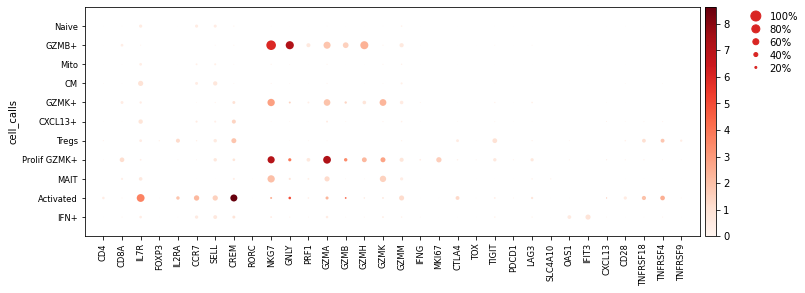

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[11.2, 0, 0.2, 0.5, 0.25])

In [34]:
marker_genes = ['CD4', 'CD8A','IL7R','FOXP3','IL2RA','CCR7','SELL','CREM','RORC',
                'NKG7','GNLY','PRF1','GZMA','GZMB','GZMH','GZMK','GZMM','IFNG','MKI67',
                'CTLA4','TOX','TIGIT','PDCD1','LAG3','SLC4A10',"OAS1", 'IFIT3',
               'CXCL13', 'CD28', 'TNFRSF18', 'TNFRSF4', 'TNFRSF9']
# , 'MT-CO2', 'MT-ATP6'
sc.pl.dotplot(adata_tcr, marker_genes, groupby='cell_calls', use_raw = True,  save = '_CD3_dotplot_w_more_gene_update_fix_sampleID.pdf')
# dendrogram = True,
# swap_axes =True, # need higher version of scanpy

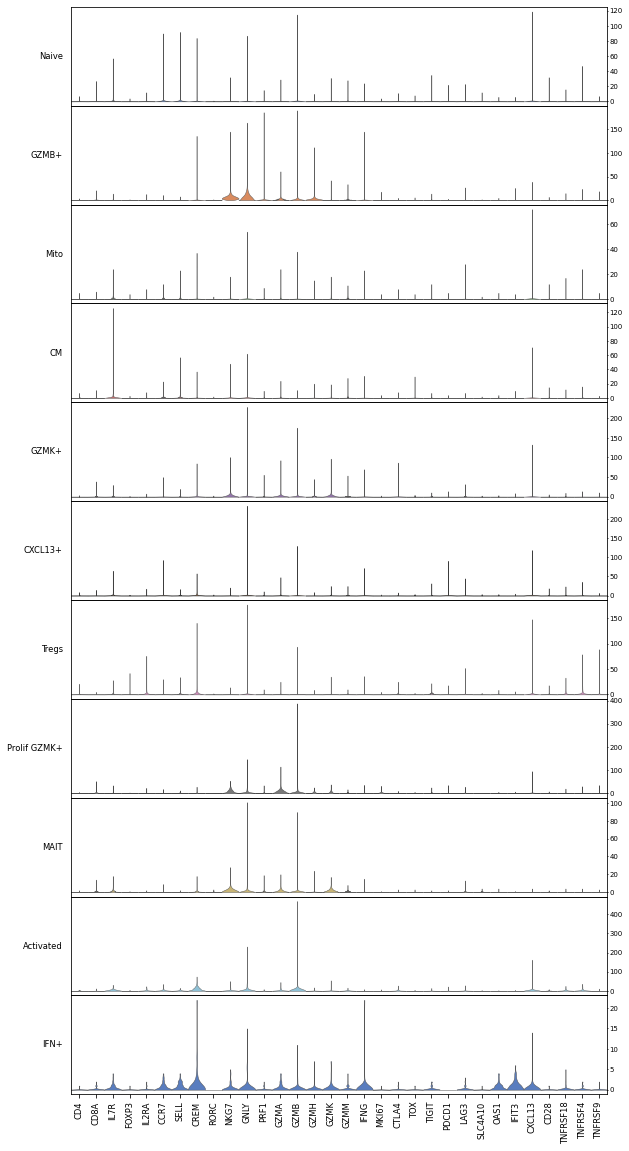

In [52]:
sc.pl.stacked_violin(adata_tcr, marker_genes, groupby='cell_calls', dendrogram=False, figsize=(10, 20), width=1.0,
                    save = '_stacked_violin_all_cells_fix_sampleID.pdf')

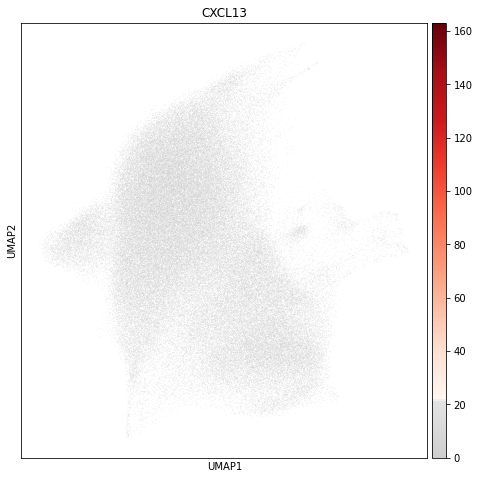

In [40]:
sc.pl.umap(adata_tcr, color =["CXCL13"],color_map=mymap)

In [42]:
adata_with_tcr_info = adata_tcr[(adata_tcr.obs['blood_tumor'].isin(['shared', 'non-shared'])) ]
adata_with_tcr_info

View of AnnData object with n_obs × n_vars = 56285 × 32738 
    obs: 'RBC', 'batch', 'comp', 'n_counts', 'n_genes', 'patient', 'percent_mito', 'platelet', 'sample', 'tissue', 'treatment', 'louvain', 'leiden', 'umap_density_comp', 'umap_density_treatment', 'umap_density_tissue', 'cell_calls', 'S_score', 'G2M_score', 'phase', 'cell.barcode', 'index_col', 'degree', 'tcr_cluster_id', 'expansion', 'blood_tumor', 'expand'
    var: 'gene_ids'
    obsm: 'X_pca', 'X_umap'

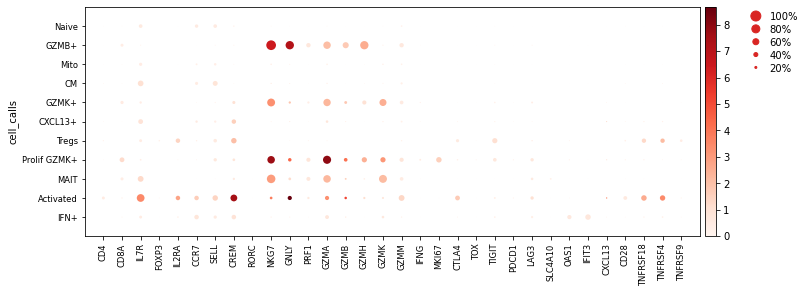

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[11.2, 0, 0.2, 0.5, 0.25])

In [35]:
marker_genes = ['CD4', 'CD8A','IL7R','FOXP3','IL2RA','CCR7','SELL','CREM','RORC',
                'NKG7','GNLY','PRF1','GZMA','GZMB','GZMH','GZMK','GZMM','IFNG','MKI67',
                'CTLA4','TOX','TIGIT','PDCD1','LAG3','SLC4A10',"OAS1", 'IFIT3',
               'CXCL13', 'CD28', 'TNFRSF18', 'TNFRSF4', 'TNFRSF9']
# , 'MT-CO2', 'MT-ATP6'
sc.pl.dotplot(adata_with_tcr_info, marker_genes, groupby='cell_calls', use_raw = True,  save = '_CD3_dotplot_w_more_gene_update_w_TCR_only_fix_sampleID.pdf')
# dendrogram = True,
# swap_axes =True, # need higher version of scanpy

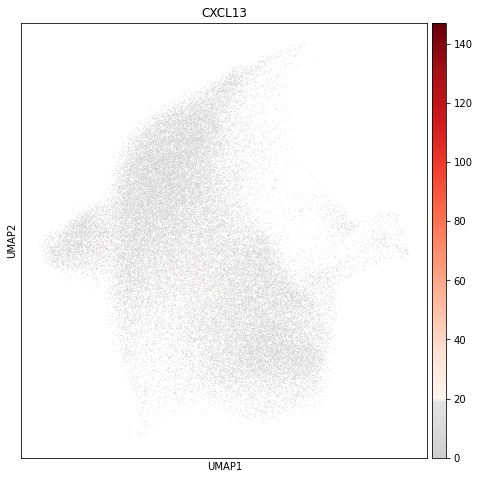

In [43]:
sc.pl.umap(adata_with_tcr_info, color =["CXCL13"],color_map=mymap)

In [44]:
adata_with_tcr_CD4_tumor = adata_tcr[(adata_tcr.obs['tissue'].isin(['tumor'])) & (adata_tcr.obs['comp'].isin(['CD4'])) & (adata_tcr.obs['blood_tumor'].isin(['shared', 'non-shared'])) ]
adata_with_tcr_CD4_tumor

View of AnnData object with n_obs × n_vars = 9164 × 32738 
    obs: 'RBC', 'batch', 'comp', 'n_counts', 'n_genes', 'patient', 'percent_mito', 'platelet', 'sample', 'tissue', 'treatment', 'louvain', 'leiden', 'umap_density_comp', 'umap_density_treatment', 'umap_density_tissue', 'cell_calls', 'S_score', 'G2M_score', 'phase', 'cell.barcode', 'index_col', 'degree', 'tcr_cluster_id', 'expansion', 'blood_tumor', 'expand'
    var: 'gene_ids'
    obsm: 'X_pca', 'X_umap'

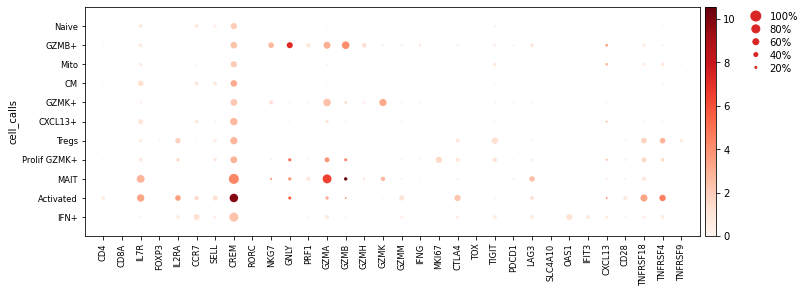

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[11.2, 0, 0.2, 0.5, 0.25])

In [33]:
marker_genes = ['CD4', 'CD8A','IL7R','FOXP3','IL2RA','CCR7','SELL','CREM','RORC',
                'NKG7','GNLY','PRF1','GZMA','GZMB','GZMH','GZMK','GZMM','IFNG','MKI67',
                'CTLA4','TOX','TIGIT','PDCD1','LAG3','SLC4A10',"OAS1", 'IFIT3',
               'CXCL13', 'CD28', 'TNFRSF18', 'TNFRSF4', 'TNFRSF9']
# , 'MT-CO2', 'MT-ATP6'
sc.pl.dotplot(adata_with_tcr_CD4_tumor, marker_genes, groupby='cell_calls', use_raw = True,  save = '_CD3_dotplot_w_more_gene_update_w_TCR_only_CD4_tumor_fix_sampleID.pdf')
# dendrogram = True,
# swap_axes =True, # need higher version of scanpy

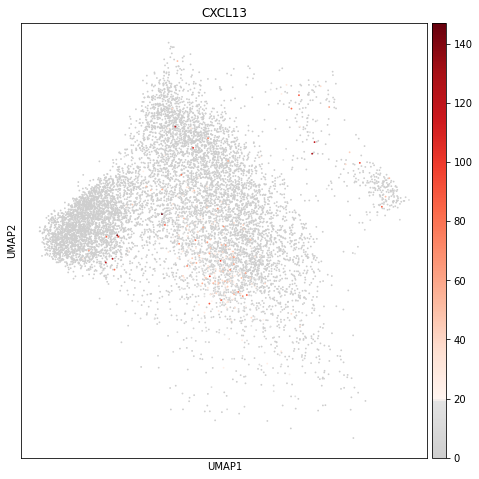

In [45]:
sc.pl.umap(adata_with_tcr_CD4_tumor, color =["CXCL13"],color_map=mymap)

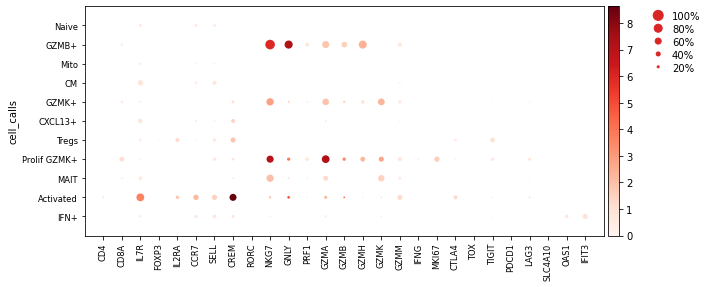

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[9.45, 0, 0.2, 0.5, 0.25])

In [50]:
marker_genes = ['CD4', 'CD8A','IL7R','FOXP3','IL2RA','CCR7','SELL','CREM','RORC',
                'NKG7','GNLY','PRF1','GZMA','GZMB','GZMH','GZMK','GZMM','IFNG','MKI67',
                'CTLA4','TOX','TIGIT','PDCD1','LAG3','SLC4A10',"OAS1", 'IFIT3',
               'CXCL13,' 'CD28', 'TNFRSF18', 'TNFRSF4', 'TNFRSF9', 'MT-CO2', 'MT-ATP6']
sc.pl.dotplot(adata, marker_genes, groupby='cell_calls', use_raw = True,  save = '_CD3_dotplot_w_more_gene_update_fix_sampleID.pdf')
# dendrogram = True,
# swap_axes =True, # need higher version of scanpy

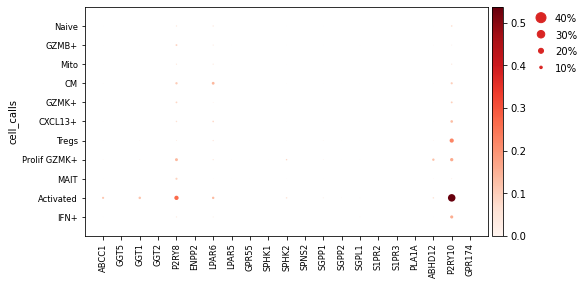

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[7.35, 0, 0.2, 0.5, 0.25])

In [52]:
marker_genes = ['ABCC1','GGT5','GGT1','GGT2','P2RY8','ENPP2','LPAR6','LPAR5','GPR55',
                'SPHK1','SPHK2','SPNS2','SGPP1','SGPP2','SGPL1','S1PR2','S1PR3','PLA1A','ABHD12','P2RY10','GPR174']
sc.pl.dotplot(adata, marker_genes, groupby='cell_calls', use_raw = True,  save = '_Larry_request_fix_sampleID.pdf')

In [19]:
path = "/wynton/group/fong/hyang7/bladder_blood_analysis/obj/"
adata_file = path + "bladder_total_adata_multiplex_Tcellonly_w_TCR_info_update.h5ad"
adata = sc.read(adata_file)
adata
# as adata have only 2008 genes, we need to get the raw gene count back and match with

AnnData object with n_obs × n_vars = 157054 × 2028 
    obs: 'RBC', 'batch', 'comp', 'n_counts', 'n_genes', 'patient', 'percent_mito', 'platelet', 'sample', 'tissue', 'treatment', 'louvain', 'leiden', 'umap_density_comp', 'umap_density_treatment', 'umap_density_tissue', 'cell_calls', 'S_score', 'G2M_score', 'phase', 'cell.barcode', 'index_col', 'degree', 'tcr_cluster_id', 'expansion', 'blood_tumor', 'expand'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_calls_colors', 'comp_colors', 'dendrogram_cell_calls', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'phase_colors', 'tissue_colors', 'treatment_colors', 'umap_density_comp_params', 'umap_density_tissue_params', 'umap_density_treatment_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [21]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

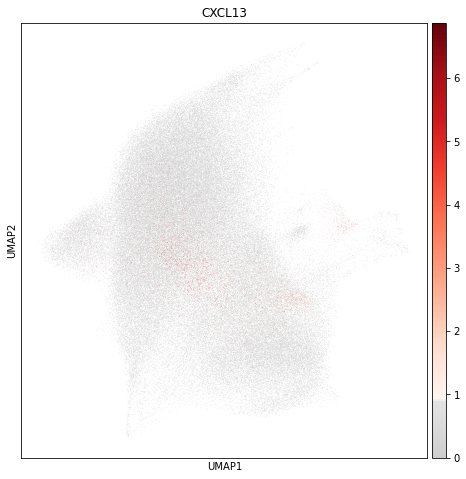

In [46]:
sc.pl.umap(adata, color =["CXCL13"],color_map=mymap,  save = '_CXCL13_normalized_gene_count_fix_sampleID.pdf')

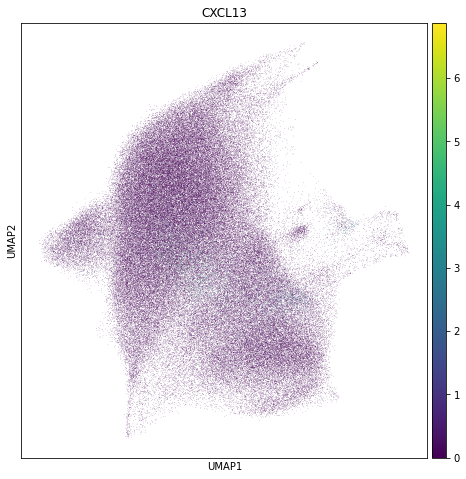

In [23]:
sc.pl.umap(adata, color =["CXCL13"])

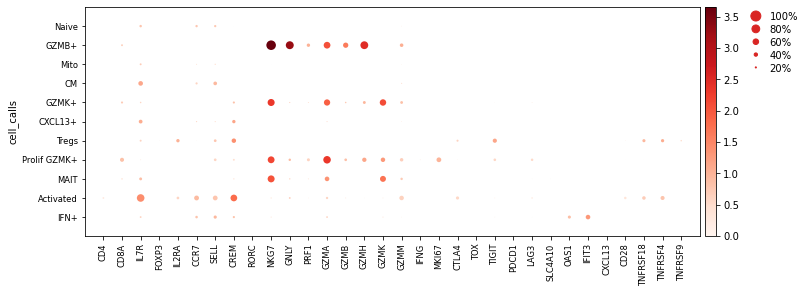

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[11.2, 0, 0.2, 0.5, 0.25])

In [26]:
marker_genes = ['CD4', 'CD8A','IL7R','FOXP3','IL2RA','CCR7','SELL','CREM','RORC',
                'NKG7','GNLY','PRF1','GZMA','GZMB','GZMH','GZMK','GZMM','IFNG','MKI67',
                'CTLA4','TOX','TIGIT','PDCD1','LAG3','SLC4A10',"OAS1", 'IFIT3',
               'CXCL13', 'CD28', 'TNFRSF18', 'TNFRSF4', 'TNFRSF9']
# , 'MT-CO2', 'MT-ATP6'
sc.pl.dotplot(adata, marker_genes, groupby='cell_calls', use_raw = True,dot_min=0.1)
# ,  save = '_CD3_dotplot_w_more_gene_update_fix_sampleID.pdf'
# dendrogram = True,
# swap_axes =True, # need higher version of scanpy

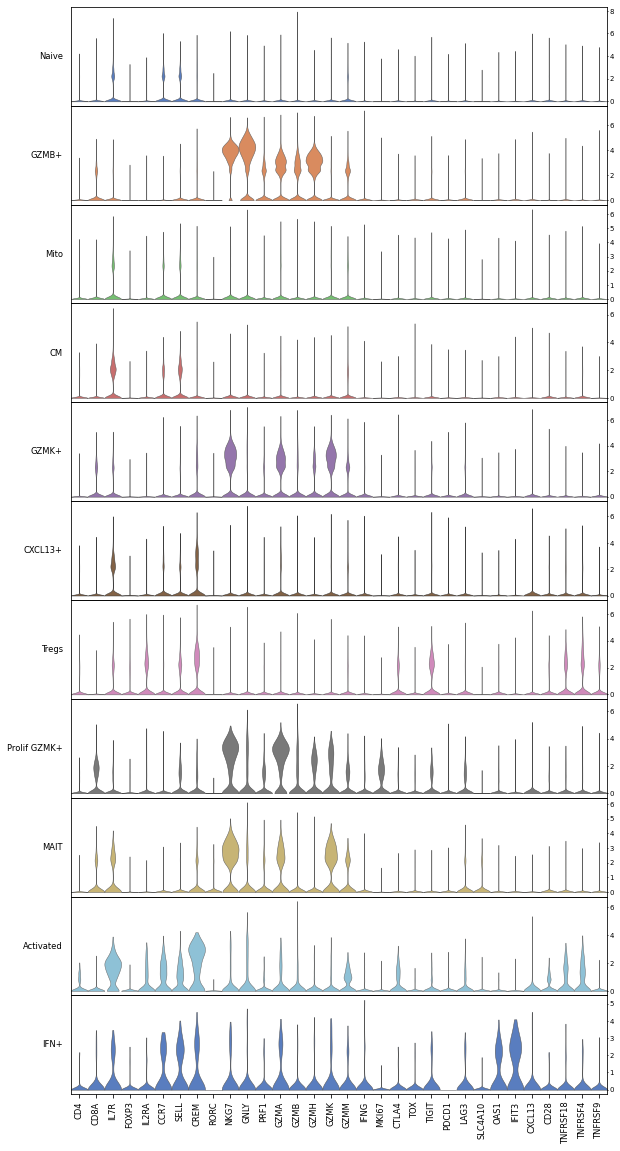

In [53]:
sc.pl.stacked_violin(adata, marker_genes, groupby='cell_calls', dendrogram=False, figsize=(10, 20), width=1.0,
                    save = '_stacked_violin_all_cells_fix_sampleID.pdf')